## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## Getting Food101 dataset from tensorflow Datasets

In [2]:
import tensorflow_datasets as tfds

In [3]:
(train_data,test_data),meta_data=tfds.load('food101',split=['train','validation'],shuffle_files=True,as_supervised=True,with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMCZHQA/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMCZHQA/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Image Preprocessing and visualization

In [4]:
#Getting all the classes
class_names=meta_data.features['label'].names

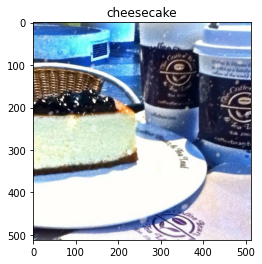

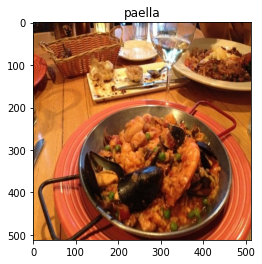

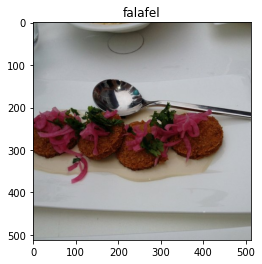

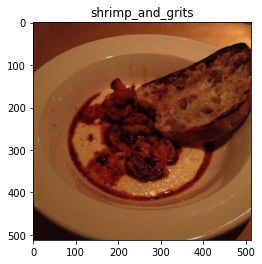

In [5]:
for img,label in train_data.take(4):
  plt.figure()
  plt.imshow(img)
  plt.title(class_names[label])

In [6]:
# Function to preprocess  the images
def preprocessor(img,label,img_size=(224,224)):
  img=tf.image.resize(img,img_size)
  tf.cast(img,dtype='float32')
  return (img,label)

In [7]:
# Preprocessing all images
train_data=train_data.map(preprocessor,num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.map(preprocessor,num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Creating an CNN Model Using Transfer Learning and fine tuning

In [12]:
from tensorflow.keras import layers

In [13]:
# Getting EfficentNetB0 as base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [19]:
# Creating an early stopping callback
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
earlystop=EarlyStopping(monitor='val_accuracy',patience=2,mode='max',verbose=0,restore_best_weights=True)
model_checkpoint_path="checkpoints/check_point1.ckpt"
model_checkpoint=ModelCheckpoint(model_checkpoint_path,monitor='val_accuracy',verbose=0,save_best_only=True,save_weights_only=True)

In [22]:
# for feature extraction
INPUT=layers.Input(shape=input_shape)
x=base_model(INPUT,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
OUTPUT=layers.Activation('softmax')(x)

In [28]:
model1=tf.keras.Model(INPUT,OUTPUT)
model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
history1=model1.fit(train_data,epochs=5,
           batch_size=32,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=0.10*len(test_data),
           callbacks=[earlystop,model_checkpoint],
           verbose=1)

Epoch 1/5
2368/2368 [==============================] - 321s 128ms/step - loss: 1.8232 - accuracy: 0.5573 - val_loss: 1.2433 - val_accuracy: 0.6677
Epoch 2/5
2368/2368 [==============================] - 298s 126ms/step - loss: 1.2942 - accuracy: 0.6676 - val_loss: 1.1223 - val_accuracy: 0.7029
Epoch 3/5
2368/2368 [==============================] - 298s 126ms/step - loss: 1.1440 - accuracy: 0.7011 - val_loss: 1.0975 - val_accuracy: 0.6994
Epoch 4/5
2368/2368 [==============================] - 298s 126ms/step - loss: 1.0466 - accuracy: 0.7254 - val_loss: 1.0653 - val_accuracy: 0.7100
Epoch 5/5
2368/2368 [==============================] - 298s 126ms/step - loss: 0.9728 - accuracy: 0.7447 - val_loss: 1.0537 - val_accuracy: 0.7168


In [30]:
model1.evaluate(test_data)

790/790 [==============================] - 98s 124ms/step - loss: 1.0671 - accuracy: 0.7105


[1.0670877695083618, 0.7104950547218323]

In [36]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

## Fine Tuning

In [41]:
base_model.trainable=True
for layer in base_model.layers[:-20]:
  layer.trainable=False


In [42]:
print(len(base_model.trainable_variables))


19


In [44]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [45]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 1,480,341
Non-trainable params: 2,698,611
_________________________________________

In [47]:
model1.load_weights(model_checkpoint_path)

In [50]:
history2=model1.fit(train_data,epochs=15,
           batch_size=32,
           initial_epoch=5,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=0.10*len(test_data),
           callbacks=[earlystop,model_checkpoint],
           verbose=1)

Epoch 6/15
2368/2368 [==============================] - 339s 143ms/step - loss: 0.3465 - accuracy: 0.9107 - val_loss: 1.1144 - val_accuracy: 0.7286
Epoch 7/15
2368/2368 [==============================] - 339s 143ms/step - loss: 0.2403 - accuracy: 0.9405 - val_loss: 1.2266 - val_accuracy: 0.7227
Epoch 8/15
2368/2368 [==============================] - 339s 143ms/step - loss: 0.1565 - accuracy: 0.9630 - val_loss: 1.3168 - val_accuracy: 0.7144


## Evaluating The Model

In [52]:
model1.evaluate(test_data)

790/790 [==============================] - 97s 122ms/step - loss: 1.1221 - accuracy: 0.7301


[1.122126817703247, 0.7300593852996826]

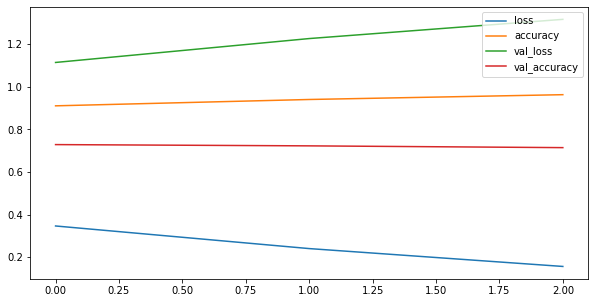

In [68]:
# plotting result
plt.figure(figsize=(10,5))
history=pd.DataFrame(history2.history)
plt.plot(history)
plt.legend(history.columns)
